# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In an earlier notebook, we investigated pipelines with a neutral/non-neutral classifier that passes its non-neutral predictions to a separate binary classifier. In this notebook, we use a negative/non-negative classifier trained on the same data used with the neutral/non-neutral classifier instead of a positive-vs-negative classifier.

A test harness is prepared for multinomial ternary classification on FRILL embeddings. The results are visualized and discussed.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# scale & resample
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import OneSidedSelection

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 6.14 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 112 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "neg",
    "neu",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 387 ms


In [6]:
# uncomment lines to undersample data
# data = data.sample(frac=0.02, random_state=SEED).sort_index()  # .head(300)
# labels = labels.loc[data.index, :]  # .head(300)

assert all(data.index == labels.index)
_ = gc_collect()

time: 135 ms


In [7]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


,source,speaker_id,speaker_gender,emo,valence,neg,neu,lang1,length
id,,,,,,,,,
0,aesdd,aesdd.1,f,ang,0,True,False,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          17703 non-null  category
 1   speaker_id      17703 non-null  category
 2   speaker_gender  17703 non-null  category
 3   emo             17703 non-null  category
 4   valence         17703 non-null  int8    
 5   neg             17703 non-null  bool    
 6   neu             17703 non-null  bool    
 7   lang1           17703 non-null  category
 8   length          17703 non-null  category
dtypes: bool(2), category(6), int8(1)
memory usage: 356.2 KB
time: 152 ms


# Strata

In this section, strata are set up for the train-test split.

In [8]:
N_SPLITS = 5

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 71446.90it/s]

time: 301 ms


In [9]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 120 ms


In [10]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
del strata
STRATA.value_counts()

merge passes performed: 0
only 1: 28
only 2: 19
only 3: 10
only 4: 5
merge passes performed: 1
only 1: 23
only 2: 9
only 3: 0
only 4: 0
merge passes performed: 2
only 1: 14
only 2: 0
only 3: 9
only 4: 0
merge passes performed: 3
only 1: 5
only 2: 0
only 3: 0
only 4: 9
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 4
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0


esdfsur0cmnmedium               984
esdfang0cmnmedium               982
esdfsad0cmnmedium               736
esdmhap2cmnmedium               689
esdfhap2cmnmedium               688
                               ... 
EmoReact_V_1.0fneu1engmedium      5
BAUM1fsad0turlong                 5
stratum_group_14                  5
stratum_group_10                  5
stratum_group_11                  5
Length: 168, dtype: int64

time: 333 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [11]:
METRICS = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_geometric_mean",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's score and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

_ = gc_collect()

time: 126 ms


In [12]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 173 ms


The cross-validation splits are pre-computed to save time in the main loops.

In [13]:
CV_info = namedtuple(
    "CV_info",
    _ := "X_train X_test y_train y_test",
    defaults=[None] * len(_.split()),
)
assert all(data.index == STRATA.index)
assert all(STRATA.index == labels.index)
prepared_splits = [
    *StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(
        X=data, y=STRATA, groups=labels.speaker_id
    )
]

scaler = lambda: MinMaxScaler(feature_range=(-1, 1))  # preserve sign
make_adasyn = lambda strategy: ADASYN(
    sampling_strategy=strategy, random_state=SEED, n_jobs=-1
).fit_resample


def get_splits(case: str, resampled: bool = True) -> List[CV_info]:
    """Prepares the three-fold cross-validation splits ternary classification."""
    splits = []
    ternary = "ternary" in case
    select_labels = labels.valence if ternary else labels.loc[:, case[:3]]
    for train_idx, test_idx in prepared_splits:
        # select and scale
        scale = scaler().fit(X_train := data.iloc[train_idx])
        X_train = scale.transform(X_train)
        X_test = scale.transform(data.iloc[test_idx])
        y_train = select_labels.iloc[train_idx]
        y_test = select_labels.iloc[test_idx]

        if resampled:
            # oversample with adasyn, undersample with oss
            try:
                train = make_adasyn("auto")(X_train, y_train)
            except ValueError:
                try:
                    train = make_adasyn("not majority")(X_train, y_train)
                except ValueError:
                    try:
                        train = make_adasyn("minority")(X_train, y_train)
                    except ValueError:
                        try:
                            train = make_adasyn("all")(X_train, y_train)
                        except ValueError:
                            train = make_adasyn("not minority")(X_train, y_train)
            X_train, y_train = OneSidedSelection(
                random_state=SEED, n_jobs=-1
            ).fit_resample(*train)

        # reset indices
        splits.append(
            CV_info(
                X_train=X_train,
                y_train=y_train.reset_index(drop=True),
                X_test=X_test,
                y_test=y_test.reset_index(drop=True),
            )
        )
    return splits


DATA_CHOOSER: Dict[str, List[CV_info]] = {case: get_splits(case) for case in ALL_CASES}

del scaler
_ = gc_collect()

time: 7min 25s


# Models

Thanks to FRILL, we may now use the gamut of binary classifiers.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Class weight parameters are set to address class imbalance. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [14]:
MODELS = {
    "Dummy": lambda: DummyClassifier(random_state=SEED),
    "LogisticRegression": lambda: LogisticRegression(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ),
    "LGBM": lambda: LGBMClassifier(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ),
    "MLP": lambda: MLPClassifier(random_state=SEED),
    "Ridge": lambda: RidgeClassifier(class_weight="balanced", random_state=SEED),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED, class_weight="balanced"),
    "SVC": lambda: SVC(random_state=SEED, class_weight="balanced"),
}

_ = gc_collect()

time: 177 ms


# Test harness

This section defines functions for evaluating models.

In [15]:
def evaluate_model(
    model_base: str, case: str, resample: bool = False, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean = [], [], [], [], []
    selected_data: List[CV_info] = DATA_CHOOSER[case]
    for fold_num in range(N_SPLITS):
        if track_fold_time:
            fold_begin = time()

        # obtain prepared folds
        fold_data: CV_info = selected_data[fold_num]

        # define train
        X_train = fold_data.X_train
        y_train = fold_data.y_train

        # define test
        X_test = fold_data.X_test
        y_test = fold_data.y_test

        # initialize binary model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        print(f"predicted in {end - begin:.2f} s")

        # store prediction results
        predict_times.append(end - begin)
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (balanced_accuracy, f1, geometric_mean, fit_times, predict_times)
        ]
    )


_ = gc_collect()

time: 131 ms


The next few cells evaluate models.

In [16]:
case = "negative"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case, track_fold_time=True),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    _ = gc_collect()

  0%|          | 0/7 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.01 s
stored Dummy for negative classification in 0.80 s
evaluating LogisticRegression...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 2.65 s
predicted in 0.00 s
LogisticRegression fold 1 completed in 2.68 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 2.38 s
predicted in 0.02 s
LogisticRegression fold 2 completed in 2.40 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 2.41 s
predicted in 0.02 s
LogisticRegression fold 3 completed in 2.43 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 2.24 s
predicted in 0.02 s
LogisticRegression fold 4 completed in 2.25 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 2.77 s
predicted in 0.00 s
LogisticRegression fold 5 completed in 2.79 s
stored LogisticRegression for negative classification in 13.35 s
evaluating LGBM...
fitted in 18.55 s
predicted in 0.11 s
LGBM fold 1 completed in 18.68 s
fitted in 18.25 s
predicted in 0.11 s
LGBM fold 2 completed in 18.38 s
fitted in 18.05 s
predicted in 0.11 s
LGBM fold 3 completed in 18.17 s
fitted in 17.46 s
predicted in 0.14 s
LGBM fold 4 completed in 17.61 s
fitted in 18.92 s
predicted in 0.14 s
LGBM fold 5 completed in 19.06 s
stored LGBM for negative classification in 92.74 s
evaluating MLP...
fitted in 21.52 s
predicted in 0.02 s
MLP fold 1 completed in 21.54 s
fitted in 25.07 s
predicted in 0.02 s
MLP fold 2 completed in 25.08 s
fitted in 22.32 s
predicted in 0.02 s
MLP fold 3 completed in 22.35 s
fitted in 21.33 s
predicted in 0.03 s
MLP fold 4 completed in 21.36 s
fitted in 22.36 s
predicted in 0.02 s
MLP fold 5 completed in 22.38 s
stored MLP for negative classification in 113.44 s
evaluati

In [17]:
case = "neutral"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case, track_fold_time=True),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    _ = gc_collect()

  0%|          | 0/7 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.02 s
fitted in 0.02 s
predicted in 0.00 s
Dummy fold 4 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for neutral classification in 0.66 s
evaluating LogisticRegression...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 3.95 s
predicted in 0.02 s
LogisticRegression fold 1 completed in 3.98 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 3.97 s
predicted in 0.00 s
LogisticRegression fold 2 completed in 3.97 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 3.82 s
predicted in 0.00 s
LogisticRegression fold 3 completed in 3.84 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 3.80 s
predicted in 0.02 s
LogisticRegression fold 4 completed in 3.81 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 3.97 s
predicted in 0.00 s
LogisticRegression fold 5 completed in 3.98 s
stored LogisticRegression for neutral classification in 20.43 s
evaluating LGBM...
fitted in 23.27 s
predicted in 0.13 s
LGBM fold 1 completed in 23.39 s
fitted in 33.58 s
predicted in 0.13 s
LGBM fold 2 completed in 33.72 s
fitted in 27.77 s
predicted in 0.11 s
LGBM fold 3 completed in 27.89 s
fitted in 25.85 s
predicted in 0.14 s
LGBM fold 4 completed in 25.99 s
fitted in 25.97 s
predicted in 0.13 s
LGBM fold 5 completed in 26.11 s
stored LGBM for neutral classification in 137.97 s
evaluating MLP...
fitted in 23.16 s
predicted in 0.02 s
MLP fold 1 completed in 23.19 s
fitted in 23.18 s
predicted in 0.02 s
MLP fold 2 completed in 23.20 s
fitted in 23.02 s
predicted in 0.02 s
MLP fold 3 completed in 23.04 s
fitted in 22.23 s
predicted in 0.02 s
MLP fold 4 completed in 22.27 s
fitted in 23.12 s
predicted in 0.02 s
MLP fold 5 completed in 23.14 s
stored MLP for neutral classification in 115.55 s
evaluating

In [18]:
case = "ternary"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case, track_fold_time=True),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    _ = gc_collect()

  0%|          | 0/7 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for ternary classification in 0.73 s
evaluating LogisticRegression...


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 8.67 s
predicted in 0.03 s
LogisticRegression fold 1 completed in 8.72 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 7.96 s
predicted in 0.03 s
LogisticRegression fold 2 completed in 8.01 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 7.60 s
predicted in 0.03 s
LogisticRegression fold 3 completed in 7.63 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 7.71 s
predicted in 0.05 s
LogisticRegression fold 4 completed in 7.75 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted in 7.60 s
predicted in 0.03 s
LogisticRegression fold 5 completed in 7.65 s
stored LogisticRegression for ternary classification in 40.60 s
evaluating LGBM...
fitted in 63.67 s
predicted in 0.12 s
LGBM fold 1 completed in 63.81 s
fitted in 59.27 s
predicted in 0.13 s
LGBM fold 2 completed in 59.41 s
fitted in 58.79 s
predicted in 0.11 s
LGBM fold 3 completed in 58.91 s
fitted in 68.03 s
predicted in 0.16 s
LGBM fold 4 completed in 68.21 s
fitted in 67.80 s
predicted in 0.15 s
LGBM fold 5 completed in 67.96 s
stored LGBM for ternary classification in 319.15 s
evaluating MLP...
fitted in 30.40 s
predicted in 0.03 s
MLP fold 1 completed in 30.44 s
fitted in 28.82 s
predicted in 0.02 s
MLP fold 2 completed in 28.84 s
fitted in 29.78 s
predicted in 0.01 s
MLP fold 3 completed in 29.82 s
fitted in 30.21 s
predicted in 0.02 s
MLP fold 4 completed in 30.25 s
fitted in 30.96 s
predicted in 0.04 s
MLP fold 5 completed in 31.00 s
stored MLP for ternary classification in 151.18 s
evaluating

Let's peek at the results.

In [19]:
results_df = (
    pd.DataFrame(results_).sort_values(by=["model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_fit_time,avg_cv_geometric_mean,avg_cv_f1,avg_cv_predict_time,model_name,case,avg_cv_balanced_accuracy
0,0.001201,0.000000,0.315900,0.001396,Dummy,negative,0.500000
1,0.001553,0.000000,0.204143,0.000200,Dummy,ternary,0.333333
2,0.003518,0.000000,0.220764,0.000196,Dummy,neutral,0.500000
3,18.247030,0.637481,0.649393,0.121871,LGBM,negative,0.643255
4,63.514382,0.504539,0.584568,0.133969,LGBM,ternary,0.541516
5,27.287065,0.641452,0.797871,0.126569,LGBM,neutral,0.684721
6,2.491212,0.635193,0.643370,0.009370,LogisticRegression,negative,0.638156
7,7.908238,0.533624,0.568103,0.034363,LogisticRegression,ternary,0.552604
8,3.901087,0.723217,0.798350,0.006245,LogisticRegression,neutral,0.737050
9,30.034786,0.542903,0.606529,0.023610,MLP,ternary,0.570701


time: 21.9 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [20]:
# set up the "metaclassifier"

case = "ternary_negneu"
ternary_hybrid_ytest: List[pd.Series] = [
    DATA_CHOOSER[case][fold].y_test for fold in range(N_SPLITS)
]  # list indexed by fold

# convenience function
get_time = lambda case, model_name, metric: results_df.query(
    f"case == '{case}' & model_name == '{model_name}'"
)[metric].values[0]

predictions_df = pd.DataFrame(predictions_)

for neutral_model in tqdm(MODELS.keys()):
    for negative_model in MODELS.keys():
        balanced_accuracy, f1, geometric_mean = [], [], []
        model_combo = f"{neutral_model}+{negative_model}"
        for fold_num in range(N_SPLITS):

            # ensemble
            fold_df = predictions_df.query(f"fold == {fold_num}")
            neutral_condition = f"case == 'neutral' & model == '{neutral_model}'"
            negative_condition = f"case == 'negative' & model == '{negative_model}'"
            query_fold = lambda criteria: fold_df.query(criteria).y_pred.item()
            df = pd.DataFrame(
                {
                    "neutral_prediction": query_fold(neutral_condition),
                    "negative_prediction": query_fold(negative_condition),
                }
            )
            del fold_df
            del negative_condition
            del neutral_condition
            del query_fold

            # "predict" 0: negative, 1: neutral, 2: positive
            df["hybrid_prediction"] = df.neutral_prediction.replace(True, 1)
            df.loc[df["hybrid_prediction"] == False, "hybrid_prediction"] = df.loc[
                df["hybrid_prediction"] == False, "negative_prediction"
            ].replace([True, False], [0, 2])
            y_pred = df.hybrid_prediction.astype(np.int8)
            del df

            # record y_pred
            store_prediction(
                where=predictions_,
                prediction=Prediction(
                    model=model_combo,
                    case="ternary_negneu",
                    fold=fold_num,
                    y_pred=y_pred,
                ),
            )

            # score
            score_params = {
                "y_true": ternary_hybrid_ytest[fold_num],
                "y_pred": y_pred,
            }
            balanced_accuracy.append(balanced_accuracy_score(**score_params))
            f1.append(f1_score(**score_params, average="weighted"))
            geometric_mean.append(geometric_mean_score(**score_params))
            del score_params
            del y_pred

            _ = gc_collect()

        # convenience function
        sum_times = lambda time_metric: get_time(
            "neutral", neutral_model, time_metric
        ) + get_time("negative", negative_model, time_metric)

        store_result(
            where=results_,
            case="ternary_negneu",
            model_name=model_combo,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy),
                np.mean(f1),
                np.mean(geometric_mean),
                sum_times("avg_cv_fit_time"),
                sum_times("avg_cv_predict_time"),
            ),
        )

        print(f"stored hybrid ternary classification results for {model_combo}")

        del balanced_accuracy
        del f1
        del geometric_mean
        del model_combo
        _ = gc_collect()

# re-define predictions_df since it has been modified
predictions_df = pd.DataFrame(predictions_)

  0%|          | 0/7 [00:00<?, ?it/s]

stored hybrid ternary classification results for Dummy+Dummy
stored hybrid ternary classification results for Dummy+LogisticRegression
stored hybrid ternary classification results for Dummy+LGBM
stored hybrid ternary classification results for Dummy+MLP
stored hybrid ternary classification results for Dummy+Ridge
stored hybrid ternary classification results for Dummy+SGD
stored hybrid ternary classification results for Dummy+SVC
stored hybrid ternary classification results for LogisticRegression+Dummy
stored hybrid ternary classification results for LogisticRegression+LogisticRegression
stored hybrid ternary classification results for LogisticRegression+LGBM
stored hybrid ternary classification results for LogisticRegression+MLP
stored hybrid ternary classification results for LogisticRegression+Ridge
stored hybrid ternary classification results for LogisticRegression+SGD
stored hybrid ternary classification results for LogisticRegression+SVC
stored hybrid ternary classification result

Let's peek at the results.

In [21]:
results_df = (
    pd.DataFrame(results_).sort_values(by=["model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_fit_time,avg_cv_geometric_mean,avg_cv_f1,avg_cv_predict_time,model_name,case,avg_cv_balanced_accuracy
0,0.001201,0.000000,0.315900,0.001396,Dummy,negative,0.500000
1,0.003518,0.000000,0.220764,0.000196,Dummy,neutral,0.500000
2,0.001553,0.000000,0.204143,0.000200,Dummy,ternary,0.333333
3,0.004719,0.000000,0.072606,0.001592,Dummy+Dummy,ternary_negneu,0.333333
4,18.250548,0.000000,0.186268,0.122067,Dummy+LGBM,ternary_negneu,0.362928
...,...,...,...,...,...,...,...
65,18.789282,0.509502,0.563697,1.524390,SVC+LogisticRegression,ternary_negneu,0.529247
66,38.816816,0.514313,0.576256,1.533769,SVC+MLP,ternary_negneu,0.538726
67,17.035568,0.512608,0.564325,1.521664,SVC+Ridge,ternary_negneu,0.531487
68,21.898903,0.506864,0.555225,1.583785,SVC+SGD,ternary_negneu,0.524932


time: 26 ms


# Results

In this section, we create several visualizations to display the results.

In [22]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_geometric_mean": "geometric mean",
    "avg_cv_predict_time": "predict time",
}

_ = gc_collect()

time: 122 ms


In [23]:
def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]
    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="case",
        hue_order=["negative", "neutral"],
        data=results_df,
        seed=SEED,
        kind="bar",
        palette=dict(
            zip(
                cases := np.unique(results_df.case),
                sns.color_palette(palette="colorblind", n_colors=len(cases)),
            )
        ),
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=2,
        title=None,
    )
    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)
    plt.xlabel("")
    plt.ylabel("")
    plt.suptitle(f"{metric_names[metric]}{' (s)' if time_metric else ''}", x=0.2, y=1)
    plt.show()


_ = gc_collect()

time: 117 ms


  0%|          | 0/5 [00:00<?, ?it/s]

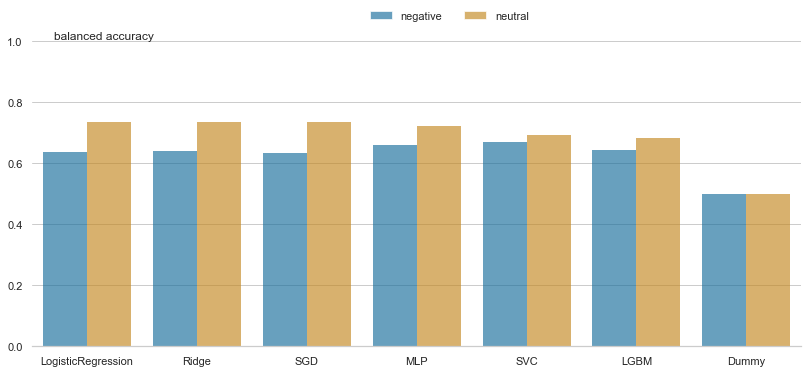

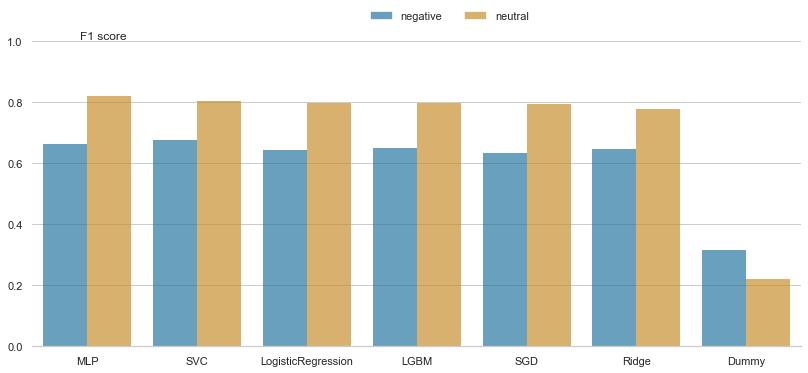

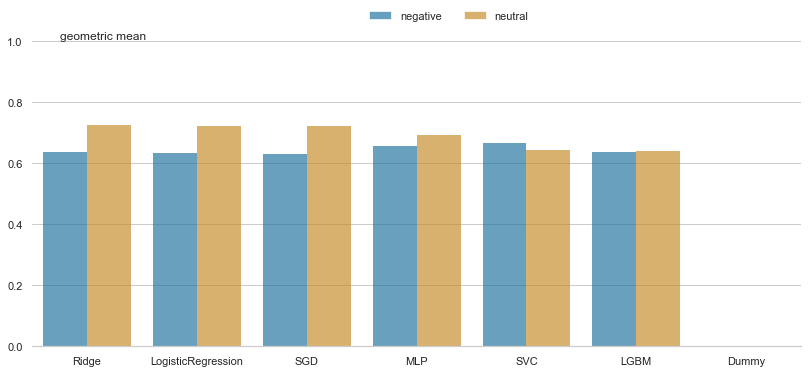

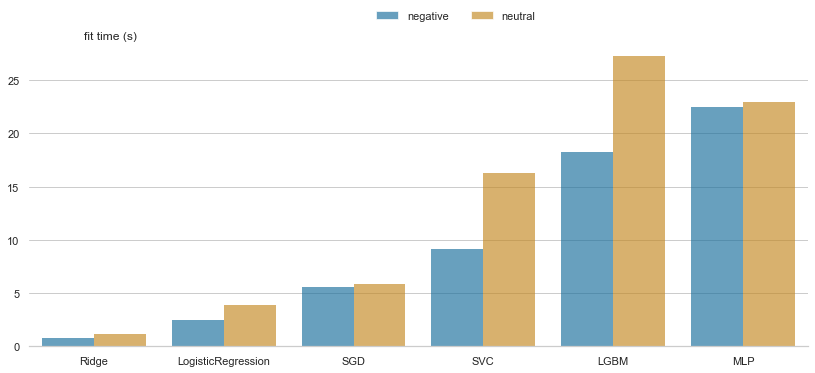

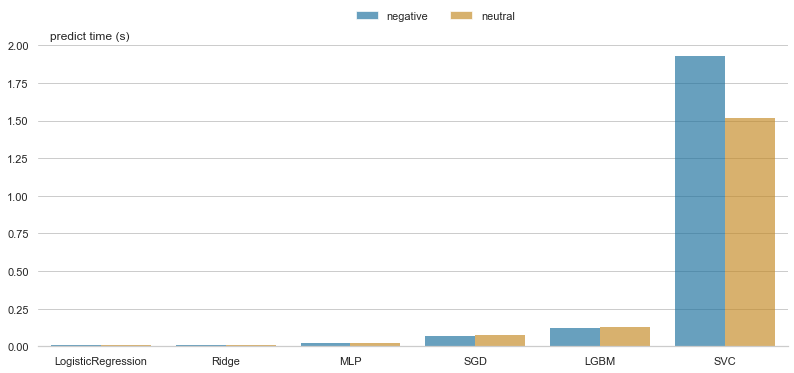

time: 2.16 s


In [24]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df.loc[~results_df.case.str.contains("ternary")])

In [25]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(10)
    g.fig.set_figheight(16)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(f"{metric_names[metric]}{' (s)' if time_metric else ''}", x=0.15)
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 122 ms


  0%|          | 0/5 [00:00<?, ?it/s]

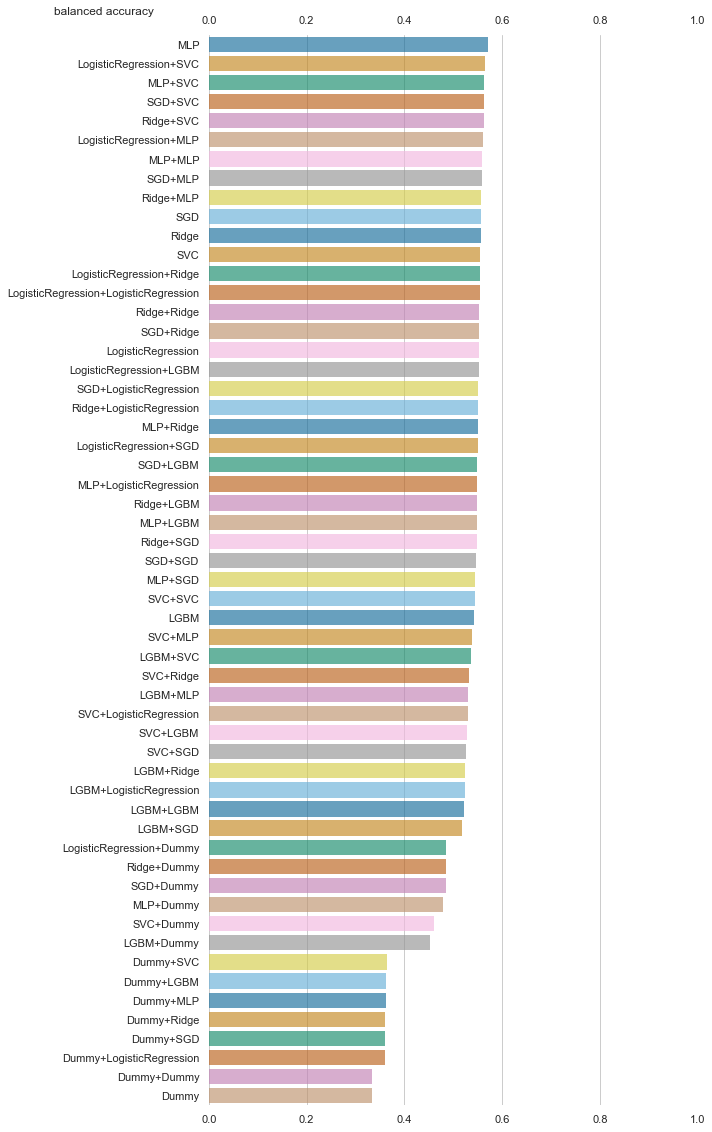

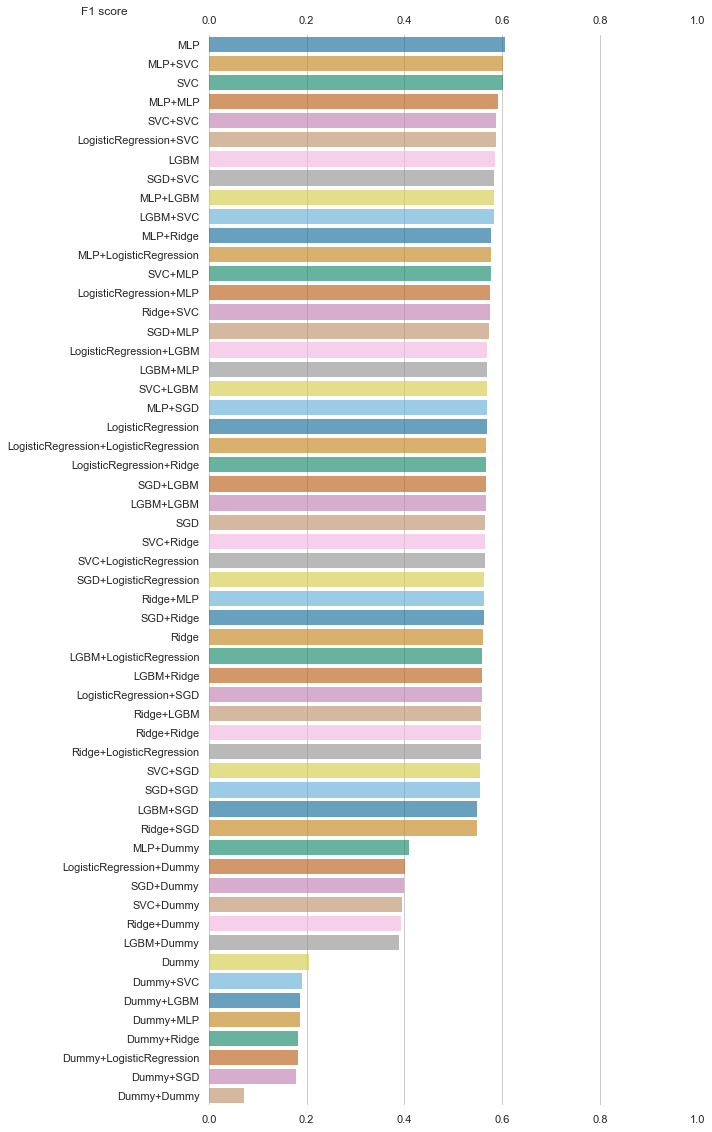

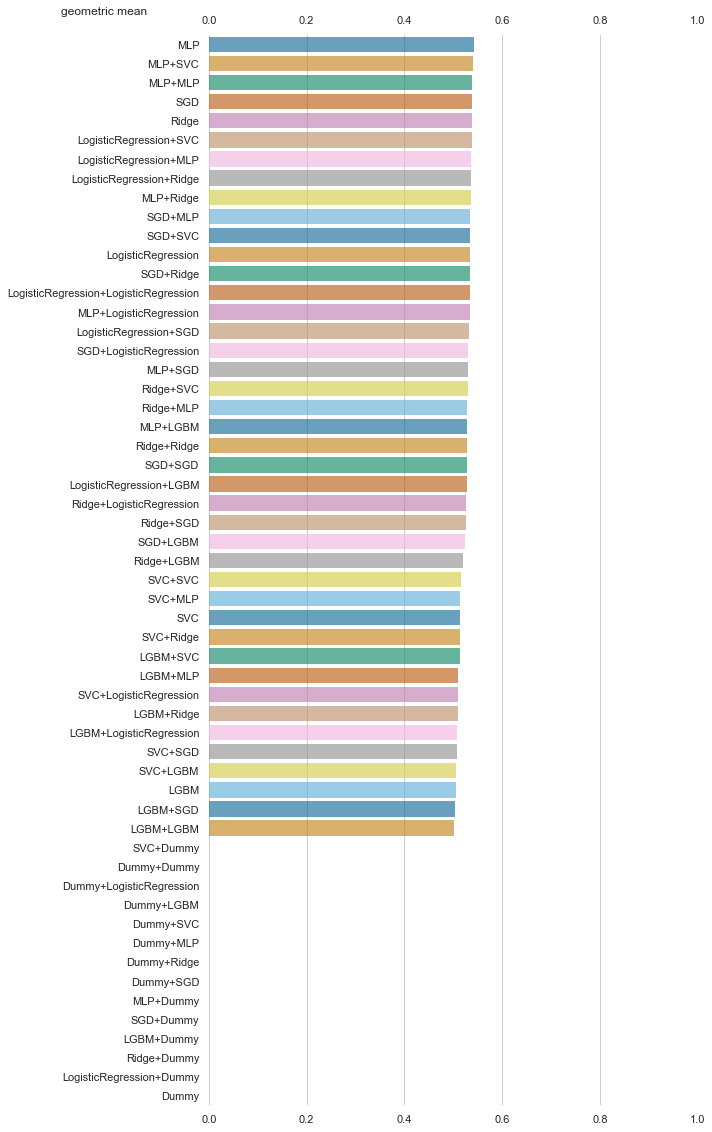

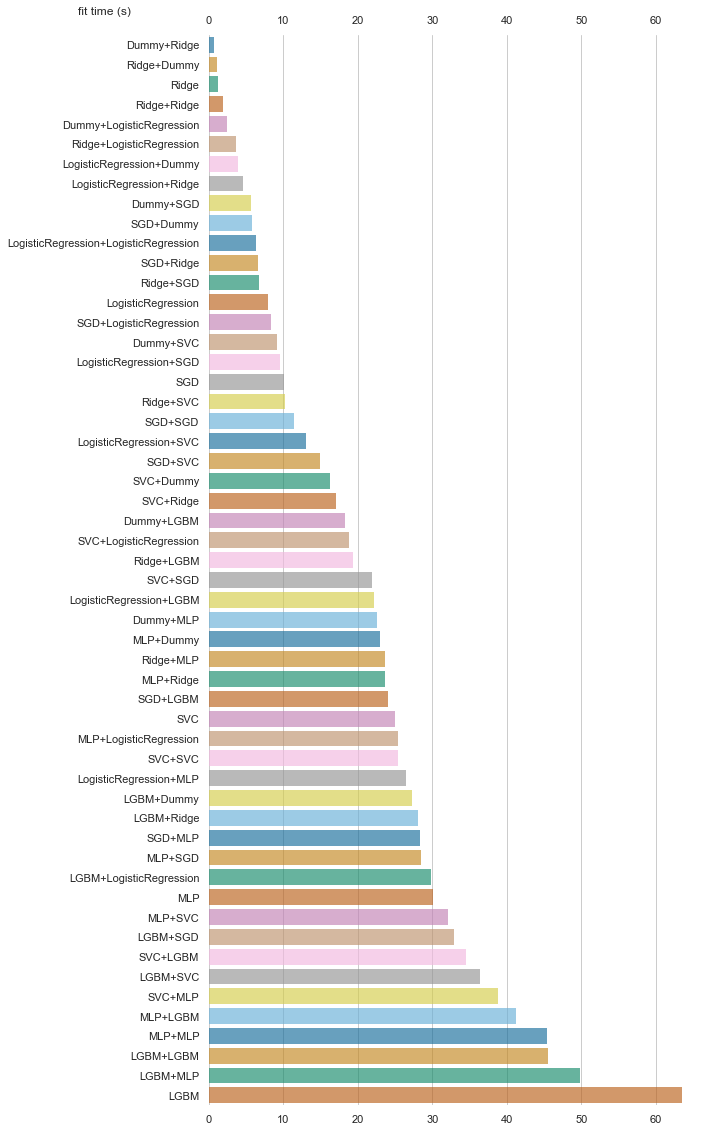

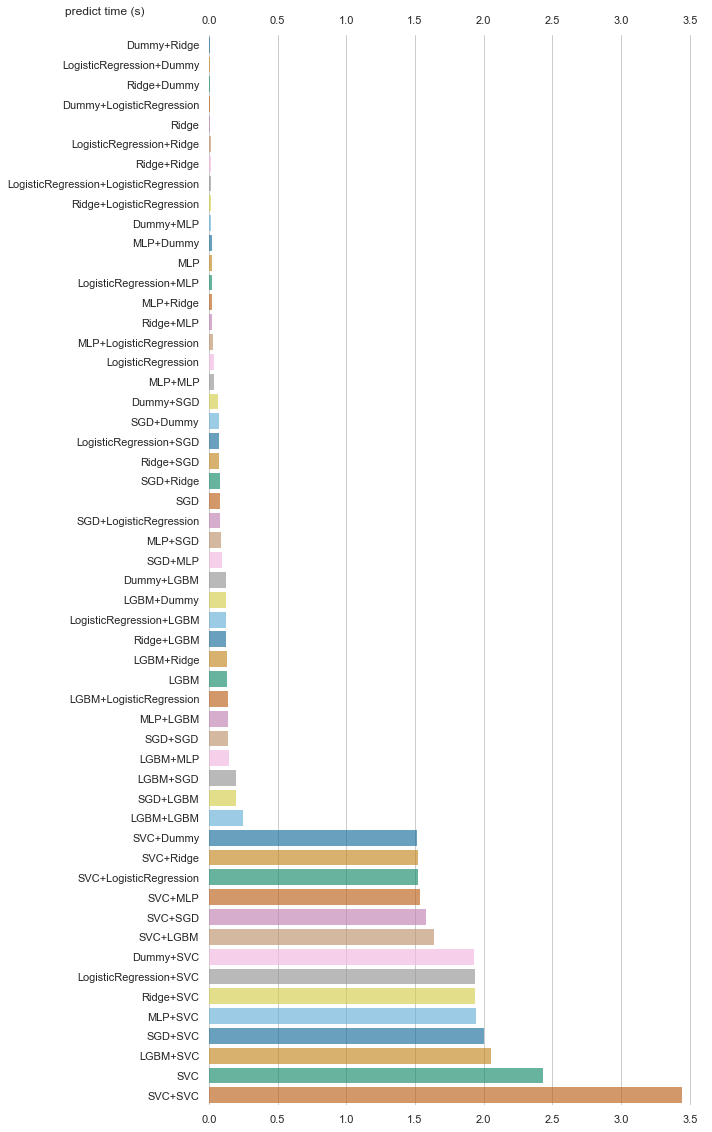

time: 8.18 s


In [26]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [30]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/explore_neg-neu_hybrid_results_CV{N_SPLITS}.csv")

time: 9.02 ms


# Discussion

In previously assessed binary classification scenarios, trained models tended to be most accurate in the neutral/non-neutral or negative/non-negative cases; this pattern of performance is mirrored in the ternary cases. Conversely, performance tended to be worst when predicting positive labels across classification scenarios. Rather than disambiguating with low-skill models, we can disambiguate just by classifying whether an ostensibly non-neutral sample is negatively valenced. The hope is that by swapping for a higher-skill disambiguator, performance will improve. The downside of this approach is that potential mixed-valence states may be harder to disentangle.

This notebook validates this approach for several models as evidenced by the high performance rankings of the two-tiered classifiers relative to that of the underlying single-tiered classifiers. Accordingly, the two-tiered classifier with the best balanced accuracy (LogisticRegression+SVC) was composed of the most performant classifiers in the respective binary cases. This effect is easily observed when considering balanced accuracy; however, it is attenuated or unobservable for the most performant classifiers examined.

The vanilla MLP from sklearn is again one of the top contenders; the highest balanced accuracy in ternary classification observed so far (just over .57) was achieved by the MLP in this notebook. This leaves open the possibility of pursuing a pure deep learning approach; I imagine a straightforward dense net with one or two hidden layers could be tuned. Yet, its scores lead only by a thin margin with models that train or predict faster closely following.

Although the MLP keeps showing up as a strong contender and thus warrants further investigation, it may be premature to discount the runner ups. This point is more salient when considering the binary scenarios, wherein the MLP is outperformed by other models depending on the task.

At this point in model selection, we know we have to consider the MLP because it has good scores. We need to decide how to sensibly carry forward or remove the other models from consideration. To this end, selecting  high-scoring models while anchoring around our most performant model (MLP) for comparison can be a guiding principle.

## Negative/non-negative classifiers

The top two estimators are SVC followed by MLP for all three scores.

## Neutral/non-neutral classifiers

MLP ranks fourth by geometric mean and balanced accuracy but first by F1 score. From best to worst, the top three estimators are LogisticRegression, Ridge, and SGD by balanced accuracy and Ridge, LogisticRegression, and SGD by geometric mean.

## Ternary classifiers

To winnow the pool of candidates, two heuristics are useful: 1) Only the candidate classifiers that rank in the top 5 by one of the three scores are considered. 2) Any two-tiered estimator that is outperformed by at least one of its subestimators alone should be eliminated from consideration.

Following these two heuristics, the candidate models that remain under each scoring metric are the following, ranked from best to worst:
* Balanced accuracy: MLP, LogisticRegression+SVC, SGD+SVC, Ridge+SVC
* F1: MLP, SVC
* Geometric mean: MLP, SGD, Ridge

## Next steps

LGBM did not make it to the top five in the ternary scenarios and did not outperform MLP in either binary scenario. It was the second slowest single model in prediction following SVC. The single-stage LGBM was actually slower in training than the two-tiered LGBM (My hunch is that something OvO or OvR could be going on under the hood, but I haven't confirmed this). Consequently, I am happy to omit LGBM from continued consideration because 1) it is the slowest to train by far, 2) it did not outperform MLP in any binary task and 3) it did not make it to the top five in any ternary task.

Since the runner ups include several linear models, PCA to condense the FRILL representations may be appropriate to explore.

In [31]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1944.2725489139557 s
time: 130 ms


[^top](#Contents)